# Sorghum growth

In [1]:
from __future__ import annotations

import os
import sys
import time as t
from datetime import date
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

sys.path.append("../data") 
from archi_dict import archi_sorghum_angles as archi
from oawidgets.plantgl import *  # noqa: F403

from openalea.archicrop.display import build_scene, display_scene  # noqa: F401
from openalea.archicrop.simulation import (
    plot_constained_vs_pot,
    plot_constrainted_vs_realized,
    plot_faPAR,
    plot_PAR,
    run_simulations,
    write_netcdf,
)
from openalea.plantgl.all import Color3, Material, Scene, Viewer  # noqa: F401

%gui qt

In [2]:
stics_color = "orange"
archicrop_color = "green"

In [3]:
tec_file_xml='../data/02NT18SorgV2D1_tec.xml'
plt_file_xml='../data/sorgho_imp_M_v10_plt.xml'
stics_output_file='../data/mod_s02NT18SorgV2D1.sti'
weather_file = '../data/ntarla_corr.2018'
location = {  
'longitude': 3.87,
'latitude': 12.58,
'altitude': 800,
'timezone': 'Europe/Paris'}

In [4]:
seed = 18

In [ ]:

start_time = t.time()

daily_dynamics, params_sets, pot_la, pot_h, realized_la, realized_h, nrj_per_plant, mtgs, filters, sowing_density = run_simulations(
    archi_params=archi, 
    tec_file=tec_file_xml, 
    plant_file=plt_file_xml, 
    dynamics_file=stics_output_file, 
    weather_file=weather_file,
    location=location,
    n_samples=10,
    latin_hypercube=False,
    pot_factor=1.5,
    opt_filter_organ_duration=False,
    opt_filter_pot_growth=False,
    opt_filter_realized_growth=False,
    light_inter=False,
    direct=False,
    error_LA_pot=1,
    error_height_pot=1,
    error_LA_realized=1,
    error_height_realized=1,
    seed=seed)

end_time = t.time()

elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.4f} minutes for {len(realized_la)} simulations")  # noqa: T201


90
3 x 4 = 12
54
3 x 1 = 3
36
3 x 3 = 9
8
Elapsed time: 0.2410 minutes for 8 simulations


In [6]:
# Retrieve STICS growth and senescence dynamics
dates = [value["Date"] for value in daily_dynamics.values()]
thermal_time = [value["Thermal time"] for value in daily_dynamics.values()]
leaf_area_plant = [value["Plant leaf area"] for value in daily_dynamics.values()]
sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in daily_dynamics.values()]
height_canopy = [value["Plant height"] for value in daily_dynamics.values()]
par_incident = [value["Incident PAR"] for value in daily_dynamics.values()]
par_stics = [value["Absorbed PAR"] for value in daily_dynamics.values()]

In [7]:
write_netcdf("sorghum_growth_tillers", daily_dynamics, params_sets, pot_la, pot_h, realized_la, realized_h, nrj_per_plant, mtgs, filters, sowing_density, seed)

In [8]:
# Viewer.display(build_scene(mtgs[3][-30])[0])

In [9]:
# mtgs[3][-40].properties()['potential_growth_rate']

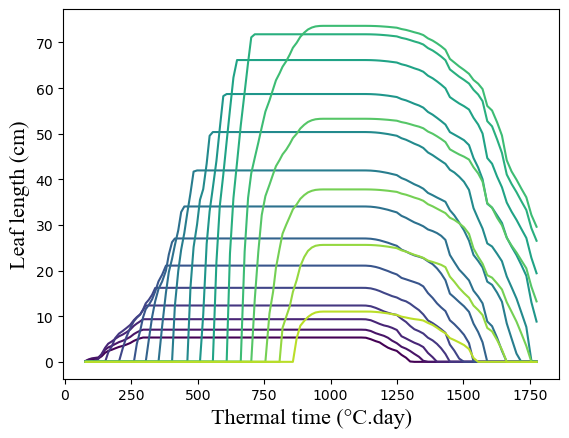

In [15]:
import os
from datetime import date

### Plot leaf lengths
id = 5
norm = plt.Normalize(0, len(mtgs[id][1].properties()["leaf_lengths"].values())+1)
cmap = plt.get_cmap('viridis')  # You can choose any matplotlib colormap

for l in range(len(mtgs[id][100].properties()["leaf_lengths"].values())):  # noqa: E741
    # print(list(growing_plant[time[1]].properties()["leaf_lengths"].values()))
    # print(list(growing_plant[time[-1]].properties()["leaf_lengths"].values()))
    color = cmap(norm(l))
    plt.plot(thermal_time[1:], 
             [list(mtgs[id][t].properties()["leaf_lengths"].values())[l][-1] - list(mtgs[id][t].properties()["senescent_lengths"].values())[l][-1] for t in range(len(thermal_time[1:]))], 
             color=color)

plt.xlabel("Thermal time (°C.day)", fontsize=16, fontname="Times New Roman")
plt.ylabel("Leaf length (cm)", fontsize=16, fontname="Times New Roman")
# plt.legend(loc="upper left")

# Save figure
today_str = date.today().strftime("%Y-%m-%d")
os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_leaf_lengths.png")

plt.show()

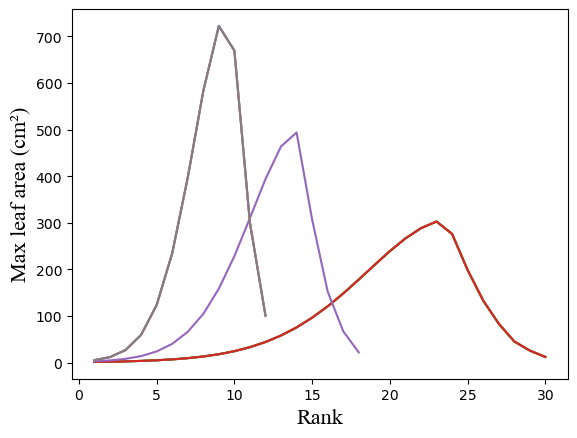

In [16]:
### Plot leaf lengths
for id in mtgs:
    leaf_areas = []
    for l in range(len(mtgs[id][1].properties()["visible_leaf_area"].values())):  # noqa: E741
        # print(list(growing_plant[time[1]].properties()["leaf_lengths"].values()))
        # print(list(growing_plant[time[-1]].properties()["leaf_lengths"].values()))
        leaf_areas.append(list(mtgs[id][-1].properties()["visible_leaf_area"].values())[l])

    plt.plot(range(1,len(leaf_areas)+1), leaf_areas) #, color="green")
plt.xlabel("Rank", fontsize=16, fontname="Times New Roman")
plt.ylabel("Max leaf area (cm²)", fontsize=16, fontname="Times New Roman")
# plt.legend(loc="upper left")

# Save figure
today_str = date.today().strftime("%Y-%m-%d")
os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_leaf_areas.png")

plt.show()

In [17]:
### Plot the 3D scene
times = [t for i,t in enumerate(thermal_time) if i%10==0]
mean_time = sum(times) / len(times)
positions = [ (1*(t-mean_time), 0, 0) for t in times]
nice_green = Color3((40, 80, 0))
scene, _ = build_scene(
    [g for i,g in enumerate(mtgs[id]) if i%10==0], 
    position=positions, 
    senescence=True, 
    leaf_material = Material(nice_green), 
    stem_material=Material(nice_green))
display_scene(scene)